**jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0**

In [ ]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
# import cv2
from os import walk

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
IMAGE_SIZE = 50
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 25420 # the number of images we use from each of the two classes

In [ ]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'


# num_train_samples = len(df_train)
# num_val_samples = len(df_val)
train_batch_size = 64
val_batch_size = 64


train_steps = 128
val_steps = 128

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255,
                             shear_range = 0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2)



# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 10168 images belonging to 2 classes.


test kode google

In [ ]:
import tensorflow.keras
import tensorflow as tf
from PIL import Image, ImageOps
import numpy as np

# Load the model
keras_model = tensorflow.keras.models.load_model('model_vgg16_trainable.h5', compile=False)
keras_model._name = 'model1'
keras_model2 = tensorflow.keras.models.load_model('model_MobileNet_trainable.h5', compile=False)
keras_model2._name = 'model2'
keras_model3 = tensorflow.keras.models.load_model('model_MobileNetV2_trainable.h5', compile=False)
keras_model3._name = 'model3'

models=[]
models.append(keras_model)
models.append(keras_model2)
models.append(keras_model3)

model_input = tf.keras.Input(shape=(50, 50, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
# model_input = tf.keras.Input(shape=models[0].input_shape[1:]) # c*h*w
# modelEns = ensembleModels(models, model_input)
# modelEns.summary()
# # ensemble_model.summary()

In [ ]:
tf.keras.utils.plot_model(ensemble_model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
# make a prediction
predictions = ensemble_model.predict(test_gen, steps=10168, verbose=1)

10168/10168 [==============================] - 196s 19ms/step


In [ ]:
predictions.shape

(10168, 2)

In [ ]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

In [ ]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_idc', 'has_idc'])

df_preds.head()

,no_idc,has_idc
0,0.903802,0.096198
1,0.963666,0.036334
2,0.768165,0.231835
3,0.999994,0.000006
4,0.996725,0.003275


In [ ]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_idc']

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.941319235738105

In [ ]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [ ]:
test_labels.shape

(10168,)

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['no_idc', 'has_idc']

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)


              precision    recall  f1-score   support

      no_idc       0.85      0.90      0.87      5084
     has_idc       0.89      0.84      0.87      5084

    accuracy                           0.87     10168
   macro avg       0.87      0.87      0.87     10168
weighted avg       0.87      0.87      0.87     10168



In [ ]:
import seaborn as sn

In [ ]:
cm = confusion_matrix(y_true, y_pred_binary)

Text(0.5, 15.0, 'Predicted label')

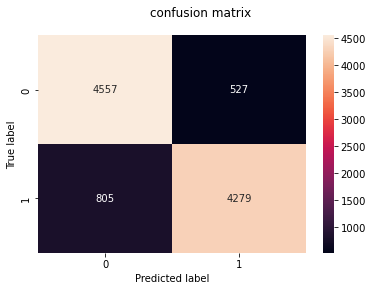

In [ ]:
fig = plt.figure()
fig.suptitle('confusion matrix')
sn.heatmap(cm, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
balanced_acc=( (cm[0,0]/(cm[0,0]+cm[0,1])) + (cm[1,1]/(cm[1,0]+cm[1,1])) )/2
# F1-score = 2 x (Recall x Precision) / (Recall + Precision)
# Recall = TP/(TP+FN))
# Precision = TP/(TP+FP)
f1_score=( 2
          *
          #recall * precission
          ((cm[1,1]/(cm[1,1]+cm[1,0])) * (cm[1,1]/(cm[1,1]+cm[0,1])))
          /
          #recall + precission
          ((cm[1,1]/(cm[1,1]+cm[1,0])) + (cm[1,1]/(cm[1,1]+cm[0,1])))
)
print(balanced_acc)
print(f1_score)

0.8690007867820614
0.8653185035389283
